C:\Users\劳煜翔\AppData\Local\Temp\ipykernel_14868\1798406503.py:91: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  sc = ax.scatter(xs, ys, zs, c='blue', s=50, cmap=custom_cmap, norm=norm)


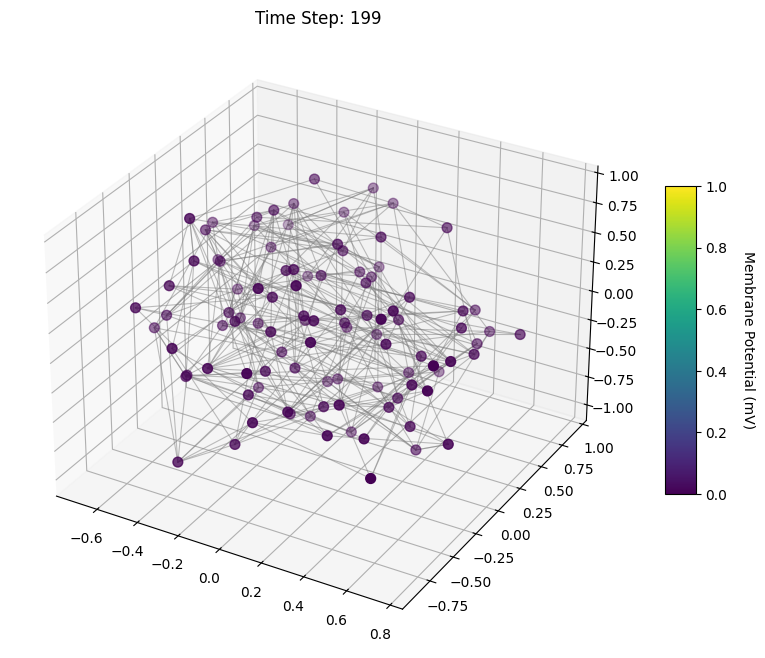

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap, BoundaryNorm

# 定义Izhikevich模型
def izhikevich(V, u, I, a, b, c, d):
    """
    Izhikevich神经元模型的动态方程
    V: 膜电位
    u: 恢复变量
    I: 外部输入
    a, b, c, d: Izhikevich模型的参数
    """
    dV = 0.04 * V**2 + 5 * V + 140 - u + I  # 膜电位的更新方程
    du = a * (b * V - u)  # 恢复变量的更新方程

    V += dV
    u += du

    # 添加复位机制
    if V >= 30:  # 当膜电位超过阈值
        V = c     # 复位膜电位
        u += d    # 恢复变量增加

    return V, u

# 创建有向小世界网络
N = 100  # 节点数量
k = 3   # 每个节点的固定出向边数量
G = nx.DiGraph()
G.add_nodes_from(range(N))
np.random.seed(42)

# 确保每个节点有6个唯一的出向边
for node in range(N):
    targets = np.random.choice([n for n in range(N) if n != node], k, replace=False)
    for target in targets:
        G.add_edge(node, target)

# 为每个节点分配三维坐标，使得相邻节点尽可能靠近
layout = nx.spring_layout(G, dim=3, seed=42)  # 使用spring layout生成3D坐标
pos = {i: layout[i] for i in range(N)}

# 初始化膜电位和恢复变量
V = np.full(N, -65.0, dtype=np.float64)  # 初始膜电位为-65 mV
V[0] = 60
u = np.full(N, 0.0, dtype=np.float64)    # 初始恢复变量为0

# 随机化每个神经元的模型参数
params = {
    "a": np.random.uniform(0.01, 0.03, N),
    "b": np.random.uniform(0.1, 0.3, N),
    "c": np.random.uniform(-68, -58, N),
    "d": np.random.uniform(2, 10, N),
}

# 设置随机输入，初始仅对一个节点施加强刺激
I = np.zeros(N)
I[0] = 150  # 增强初始输入强度，确保刺激传播

# 创建传播权重矩阵（固定随机权重）
W = np.zeros((N, N))
for i, j in G.edges():
    W[i, j] = np.random.uniform(0.8, 1.2)  # 权重在 0.8 到 1.2 之间波动

# 动态绘制的设置
T = 200  # 模拟的时间步数

# 提取节点的三维坐标
xs, ys, zs = zip(*[pos[i] for i in range(N)])

# 自定义颜色映射
colors_under_50 = plt.cm.Greys(np.linspace(0.3, 0.7, 256))  # 深色灰色渐变，增强敏感度
colors_50_to_70 = plt.cm.viridis(np.linspace(0.6, 1.0, 128))  # 敏锐亮色渐变
colors_above_70 = plt.cm.autumn(np.linspace(0.5, 1.0, 128))  # 高电位亮色渐变
all_colors = np.vstack((colors_under_50, colors_50_to_70, colors_above_70))
custom_cmap = ListedColormap(all_colors)

# 设置颜色的边界和分段
boundaries = [-80, -50, -70, 80]  # 分段边界
norm = BoundaryNorm(boundaries, custom_cmap.N, clip=True)

# 创建图形和3D子图
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 初始化节点和边的绘图元素
sc = ax.scatter(xs, ys, zs, c='blue', s=50, cmap=custom_cmap, norm=norm)

# 绘制有向边
lines = []
for i, j in G.edges():
    x_vals = [pos[i][0], pos[j][0]]
    y_vals = [pos[i][1], pos[j][1]]
    z_vals = [pos[i][2], pos[j][2]]
    line, = ax.plot(x_vals, y_vals, z_vals, color='gray', alpha=0.5, linestyle='-', linewidth=0.8)
    lines.append(line)

# 更新函数
def update(t):
    global V, u, I

    # 动态更新每个节点的输入电流
    new_I = np.zeros(N)
    for i in range(N):
        if V[i] > 0:  # 仅在膜电位大于0时向邻居传播刺激
            neighbors = list(G.successors(i))  # 获取出向邻居
            for j in neighbors:
                new_I[j] += W[i, j] * (V[i]*2 - params["c"][i])  # 根据膜电位生成刺激

    # 更新输入电流并添加随机噪声
    I = new_I + np.random.uniform(-0.5, 0.5, N)

    # 更新膜电位和恢复变量
    for i in range(N):
        V[i], u[i] = izhikevich(V[i], u[i], I[i], params["a"][i], params["b"][i], params["c"][i], params["d"][i])
        V[i] = np.clip(V[i], -80, 80)  # 限制膜电位的范围

    # 更新节点颜色
    sc.set_array(V)

    ax.set_title(f"Time Step: {t}")
    return sc, *lines
# 添加颜色条
cbar = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=5)  # 调整颜色条的大小
cbar.set_label('Membrane Potential (mV)', rotation=270, labelpad=20)  # 设置颜色条标签


# 创建动画
ani = FuncAnimation(fig, update, frames=T, interval=200, blit=False)  # interval设置为200ms，放慢演化速度

# 保存动画为GIF文件
ani.save("izhikevich_network_fixed_propagation.gif", writer="pillow")

# 显示动画
plt.show()